# UV-Guider alignement with source in autocoll
##  Field 1

In [1]:
cd ../..

/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/instrument alignment focusing/XY_calibration/FireBallPipe


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from Calibration.mapping import Mapping

## initialization from last xy calib

In [3]:
G2UV = Guider2UV(filename='Notebook/2018/data_needed_to_run_notebooks/F1_180826.pkl')
print(G2UV)

FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>): (lon, lat) in deg
    [(0.17436856, 0.00516991)]>
FOV center pixel position in guider [array([1330.61038367]), array([560.93947921])]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (32.19, -5.688)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.392728151  36.4185638082  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024551548564194  0.00024661678545423  
NAXIS : 0  0

    mask_rotation: 83.96815071133501 

In [4]:
target_filename = 'Calibration/Targets/2022/targets_F1.csv'
F1 = Table.read(target_filename, format='ascii')

## Diffuse UV image

load new mapping

In [5]:
mask_det_map_file = 'Notebook/2018/data_needed_to_run_notebooks/mapping-mask-det-180612-F1.pkl'
mask_det_map = Mapping(mask_det_map_file)
G2UV.set_detector_mapping(mask_det_map, offsets = [1., 1.])


## Scan sequence

GC - 46 - 51 - 14 - 8 - 12 - 16 - 38 - 44

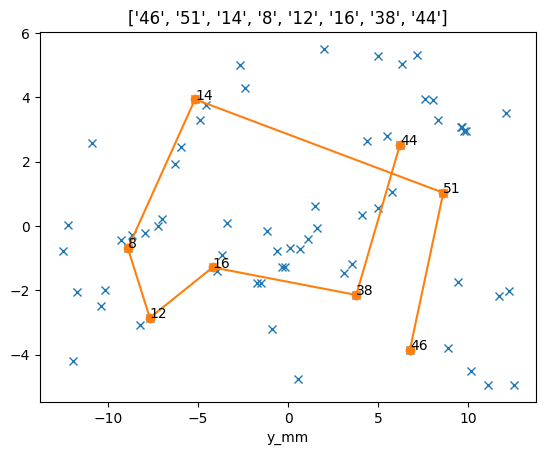

KeyError: 'ra'

In [6]:

slits = ['46', '51', '14', '8', '12', '16', '38', '44'] 

F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

ra,dec = "ra", "dec"

plt.figure()
plt.plot(F1["x_mm"],F1["y_mm"],"x")
plt.plot(selected_slits["x_mm"],selected_slits["y_mm"],"-o")
for s in selected_slits:
    plt.text(s["x_mm"],s["y_mm"],s["Internal-count"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title(slits)
plt.show()

selected_slits = selected_slits['Internal-count',"x_mm","y_mm",ra,dec]
slit_path = vstack((selected_slits,selected_slits[::-1]) )
# slit_path["ra_diff"] = [0] + list((slit_path[ra][1:] - slit_path[ra][:-1])*np.cos(slit_path[dec][:-1]*np.pi/180)) 
# slit_path["dec_diff"] = [0] + list((slit_path[dec][1:] - slit_path[dec][:-1])) 
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path

# selected_slits

In [7]:



moves, flags, slits_coord = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = True)

print(moves,flags)
moves_tab = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
print(moves_tab)
assert moves.sum(axis=0)[0] <0.1
assert moves.sum(axis=0)[1] <0.1
# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves_tab["UV_image"] = moves_tab["UV_image"].astype(bool)
try:
    moves_tab.to_clipboard()
except Exception:
    pass
moves_tab 
# print(slit_path.to_pandas(), moves_tab[moves_tab["UV_image"]])
from astropy.table import hstack
# print(len(slit_path),len(moves_tab[moves_tab["UV_image"]]))
print(hstack((slit_path, Table.from_pandas(moves_tab[moves_tab["UV_image"]][2:]))))

# pd.concat([slit_path.to_pandas(), moves_tab[moves_tab["UV_image"]][2:]], axis=1)
# hstack((slit_path,moves_tab[moves_tab["UV_image"]]))

slit position in mm on mask: [ 6.7589561 -3.858979 ]
slit position in mm on mask: [8.6160157 1.0303866]
slit position in mm on mask: [-5.1696728  3.934102 ]
slit position in mm on mask: [-8.8972191 -0.6960435]
slit position in mm on mask: [-7.6793793 -2.8581218]
slit position in mm on mask: [-4.190085  -1.2881544]
slit position in mm on mask: [ 3.7831595 -2.1462593]
slit position in mm on mask: [6.2134041 2.5275849]

targets local coords in siderostat local frame:
EL: 155.8 arcsec ; CE: 274.8 arcsec
EL: 365.4 arcsec ; CE: 346.9 arcsec
EL: 474.4 arcsec ; CE: -227.1 arcsec
EL: 273.9 arcsec ; CE: -377.0 arcsec
EL: 183.3 arcsec ; CE: -324.2 arcsec
EL: 253.7 arcsec ; CE: -181.2 arcsec
EL: 225.5 arcsec ; CE: 149.7 arcsec
EL: 426.4 arcsec ; CE: 245.7 arcsec

siderostat moves sequence: 
[[   0.          -30.        ]
 [  -0.           30.        ]
 [ 155.79863822  274.80731595]
 [ 209.5897664    72.04872165]
 [ 108.96407364 -573.93587185]
 [-200.47576394 -149.87035271]
 [ -90.56193597   52.702

NameError: name 'slit_path' is not defined

observed slits position :

In [8]:
slits_coord_obs_det = np.array([
       [1965.59756538,  420.22242579],
       [1631.74361865,  289.23423754],
       [1467.73408468, 1349.36778046],
       [1784.27150004, 1626.79774278],
       [1927.70920124, 1532.48181218],
       [1818.74748265, 1266.98195373],
       [1859.64545293,  654.1904897 ],
       [1539.18268865,  478.63015312],
#retour
       [1538.98978056,  473.42365165],
       [1859.70918054,  650.33623459],
       [1819.23982594, 1263.17030059],
       [1927.97229623, 1527.29654425],
       [1784.71779993, 1630.64211506],
       [1468.24324699, 1354.89013602],
       [1631.89394058,  287.11784832],
       [1966.20476903,  416.24326822]])

# slits_coord_obs_det
slit_path["x_det_obs"] = slits_coord_obs_det[:,0]
slit_path["y_det_obs"] = slits_coord_obs_det[:,1]
slit_path


NameError: name 'slit_path' is not defined

NameError: name 'slit_path' is not defined

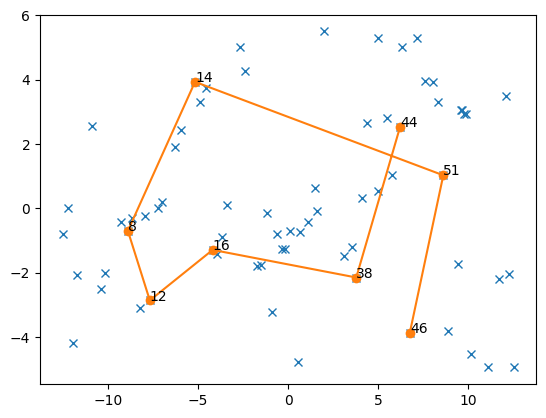

In [9]:
# TODO create some quiver of the error
plt.figure()
plt.plot(F1["x_mm"],F1["y_mm"],"x")
plt.plot(selected_slits["x_mm"],selected_slits["y_mm"],"-o")
for s in selected_slits:
    plt.text(s["x_mm"],s["y_mm"],s["Internal-count"])
plt.quiver(slit_path["x_mm"],slit_path["y_mm"],slit_path["x_det_obs"],slit_path["y_det_obs"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title("F1 : %s"%(slits))
plt.show()

In [10]:
valid = np.isfinite(slits_coord_obs_det[:,0])
#valid = np.array([True]*8 + [False]*8)
obs_wave = G2UV.mask_det_map.w[0]
print("wave: ", obs_wave)

slits_coord_valid = [slits_coord[i] for i in np.nonzero(valid)[0]]
slits_valid = np.array(slits + slits[::-1])[valid]

wave:  0.20255


In [11]:
%%script false --no-raise-error
mid  = len(slits_coord_obs_det)//2
pair_diff = slits_coord_obs_det[:mid] - slits_coord_obs_det[::-1][:mid]
pair_diff
plt.figure()
plt.subplot('120')
plt.plot(pair_diff[:,0],'*')
plt.plot(np.abs(pair_diff[:,0]),'-')
plt.title("El pair diff")
plt.ylabel("El arcsec")
plt.subplot('121')
plt.plot(pair_diff[:,1],'*')
plt.plot(np.abs(pair_diff[:,1]),'-')
plt.title("Ce pair diff")
plt.ylabel("Ce arcsec")


In [12]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )

Fitting rotation and translation
theta: -39.64406827086573 arcmin
dx: 1.464005083149573 arcsec
dy: 4.999176034293234 arcsec
variances: [1.41357633 0.250191   0.34888419]

residuals in arcsec: [[ 1.34364537  0.90589971]
 [-0.10455587  2.2767965 ]
 [ 1.24154759 -5.28553431]
 [ 0.70985269 -2.75410549]
 [-0.11866099  3.95209756]
 [-1.06013003  2.03181451]
 [ 0.1657948   2.63474   ]
 [-0.61370603  4.49278225]
 [-0.42171165 -1.2780589 ]
 [ 0.09530035 -1.66658773]
 [-1.63924073 -2.19436836]
 [-0.37024996 -1.78691218]
 [ 0.04974544  1.5006417 ]
 [ 0.49990887  0.83870242]
 [-0.32745232 -0.0855995 ]
 [ 0.54991248 -3.58230817]]
max residual in EL,CE 1.6, 5.3 arcsec
mean residual in EL,CE 0.8, 2.7 arcsec


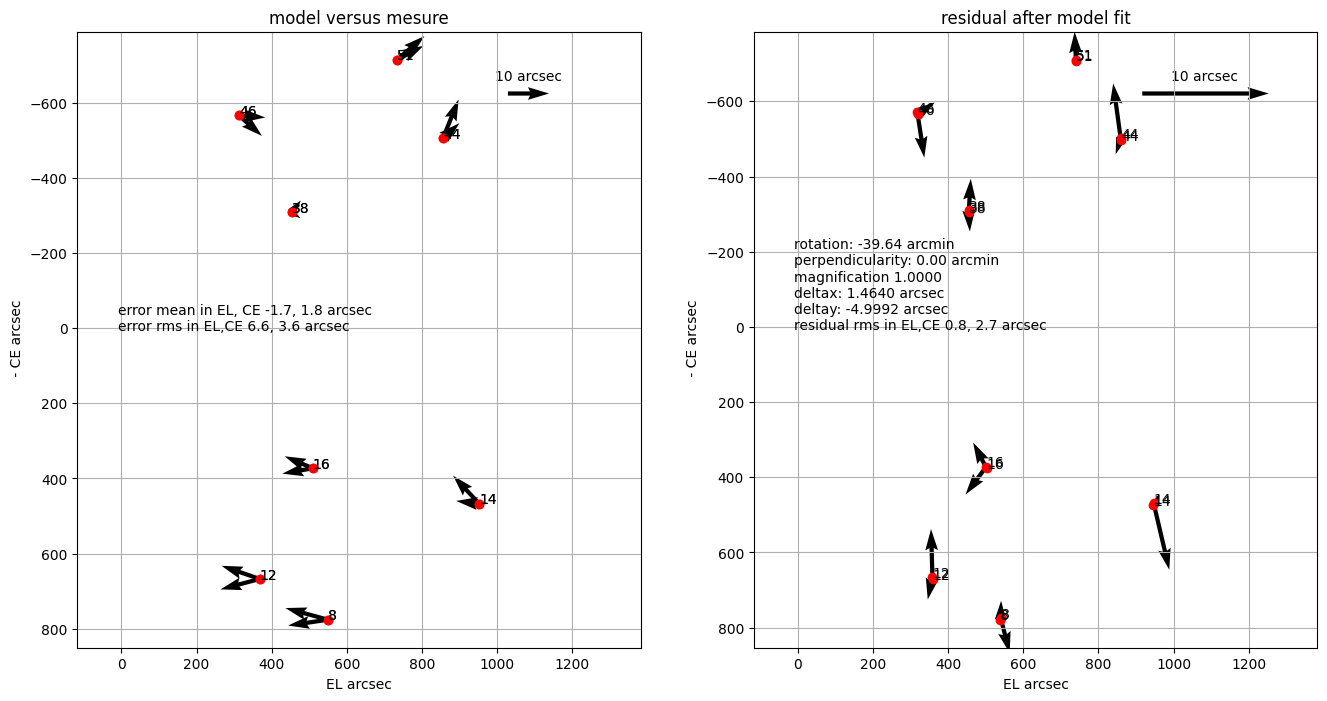

After updating:
    mask_rotation: 44.32408244046928 arcmin
    FOV center in guider: [1332.40166354] x [558.51796435] pix = [629.40544409] arcsec x [16.37190667] arcsec arcsec
    mask_magnification correction: 1.0  
    


In [13]:
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)

G2UVcor = G2UV.update_model(slits_coord_valid, slits_coord_obs, labels=slits_valid, plot=True, figsize=(16,8))[0]

In [14]:
#G2UVcor.save(filename=cloudpath + 'TestsFTS2018-Flight/E2E-AIT-Flight/XYCalibration/F1_180904.pkl')

In [15]:
CEg, Elg = 1.02928, 1.00379


moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = True, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))


moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]
moves["UV_image"] = moves["UV_image"].astype(bool)
new_cat = hstack((slit_path,moves[moves["UV_image"]][1:-1]))
new_cat
new_cat["EL_moves"] =  list(new_cat["EL_abs"][1:] - new_cat["EL_abs"][:-1]) +  [0]
new_cat["CE_moves"] =  list(new_cat["CE_abs"][1:] - new_cat["CE_abs"][:-1]) +  [0]



new_cat["El_sky"] = new_cat["EL_moves"]  * 2 * Elg 
new_cat["Cel_sky"] = new_cat["CE_moves"] * 2 * CEg 
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
#new_cat.to_pandas().to_clipboard()
new_cat["ra_diff","dec_diff","EL_moves","CE_moves","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]

# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# moves.to_clipboard()
# moves

# from astropy.table import hstack 
# # Table.from_pandas(a[moves_tab["UV_image"]])[2:]
# print(moves_tab[moves_tab["UV_image"]],len(moves_tab[moves_tab["UV_image"]]))

# new_cat = hstack((slit_path,Table.from_pandas(moves_tab[moves_tab["UV_image"]])[2:]))
# print(Elg,CEg)
# new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg 
# new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg 
# new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
# new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
# new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
# new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# # new_cat
# new_cat.to_pandas().to_clipboard()
# new_cat

slit position in mm on mask: [ 6.7589561 -3.858979 ]
slit position in mm on mask: [8.6160157 1.0303866]
slit position in mm on mask: [-5.1696728  3.934102 ]
slit position in mm on mask: [-8.8972191 -0.6960435]
slit position in mm on mask: [-7.6793793 -2.8581218]
slit position in mm on mask: [-4.190085  -1.2881544]
slit position in mm on mask: [ 3.7831595 -2.1462593]
slit position in mm on mask: [6.2134041 2.5275849]

targets local coords in siderostat local frame:
EL: 153.3 arcsec ; CE: 274.1 arcsec
EL: 362.0 arcsec ; CE: 348.4 arcsec
EL: 477.7 arcsec ; CE: -224.1 arcsec
EL: 279.1 arcsec ; CE: -376.2 arcsec
EL: 187.9 arcsec ; CE: -324.5 arcsec
EL: 256.5 arcsec ; CE: -180.7 arcsec
EL: 224.5 arcsec ; CE: 149.8 arcsec
EL: 424.2 arcsec ; CE: 248.0 arcsec

siderostat moves sequence: 


NameError: name 'slit_path' is not defined

### plot corrected positions vs real source positions on sky

#### with magnification correction (1.0006)

In [16]:
slit_coords, source_coords = G2UVcor.compare_mask_2_sky(slits, F1, slits_valid, scale=1/500.,quiverscale=0.5)

KeyError: 'ra'

In [17]:
slit_coords_all, source_coords_all = G2UVcor.compare_mask_2_sky(F1['Internal-count'], F1, scale=1/500, quiverscale=0.5)

KeyError: 'ra'

In [18]:
origin = slit_coords_all[0].origin
radius = []
delta = np.zeros((len(slit_coords_all),2))
delta_norm = []
delta_dot_radius = []

for i,(s,g) in enumerate(zip(slit_coords_all, source_coords_all)):
    r = np.sqrt( g.lon*g.lon + g.lat*g.lat).to(u.arcsec).value
    radius.append(r) 
    delta[i] = np.array([(s.lon-g.lon).to(u.arcsec).value, (s.lat-g.lat).to(u.arcsec).value])
    delta_norm.append(np.sqrt(np.square(delta[i]).sum()))
    delta_dot_radius.append( ((s.lon-g.lon).to(u.arcsec).value * g.lon.to(u.arcsec).value +
                             (s.lat-g.lat).to(u.arcsec).value * g.lat.to(u.arcsec).value ) / r)
    
plt.figure()
plt.scatter(radius, np.array(delta_norm)/np.array(radius))
plt.xlabel('distance to center (arcesc)')
plt.title('deviation norm over radial distance')
plt.grid(True)
plt.ylim((6.1e-4-1e-5,6.1e-4+1e-5))


plt.figure()
plt.scatter(radius, np.array(delta_dot_radius)/np.array(radius))
plt.xlabel('distance to center (arcesc)')
plt.title('signed radial deviation over radial distance')
plt.grid(True)
plt.ylim((6.1e-4-1e-5,6.1e-4+1e-5))


NameError: name 'slit_coords_all' is not defined

#### without magnification correction

In [19]:
G2UV_test = G2UVcor.copy()
G2UV_test.FieldP.gamma = 1.
slit_coords_all, source_coords_all = G2UV_test.compare_mask_2_sky(F1['Internal-count'], F1, scale=1e-5, quiverscale=0.005)

KeyError: 'ra'

In [20]:
origin = slit_coords_all[0].origin
radius = []
delta = np.zeros((len(slit_coords_all),2))
delta_norm = []
delta_dot_radius = []

for i,(s,g) in enumerate(zip(slit_coords_all, source_coords_all)):
    r = np.sqrt( g.lon*g.lon + g.lat*g.lat).to(u.arcsec).value
    radius.append(r) 
    delta[i] = np.array([(s.lon-g.lon).to(u.arcsec).value, (s.lat-g.lat).to(u.arcsec).value])
    delta_norm.append(np.sqrt(np.square(delta[i]).sum()))
    delta_dot_radius.append( ((s.lon-g.lon).to(u.arcsec).value * g.lon.to(u.arcsec).value +
                             (s.lat-g.lat).to(u.arcsec).value * g.lat.to(u.arcsec).value ) / r)
    
plt.figure()
plt.scatter(radius, np.array(delta_norm)/np.array(radius))
plt.xlabel('distance to center (arcesc)')
plt.title('deviation norm over radial distance')
plt.grid(True)
plt.ylim((-1e-5,1e-5))


plt.figure()
plt.scatter(radius, np.array(delta_dot_radius)/np.array(radius))
plt.xlabel('distance to center (arcesc)')
plt.title('signed radial deviation over radial distance')
plt.grid(True)
plt.ylim((-1e-5,1e-5))


NameError: name 'slit_coords_all' is not defined

## Star sequence

gc - s8 - s25 - s31

In [23]:
star_target_path = cloudpath + 'Target_selection/GuidingStars/'

F1_stars = Table.read(star_target_path + "F1_guidingstars.fits", format='fits')

stars = [8, 25, 31]

star_movs, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = True)


NameError: name 'cloudpath' is not defined

In [22]:
stars_coord

NameError: name 'stars_coord' is not defined

------------------------------------------------------

Re-compute model (thermal drift) ?

In [ ]:
slits_coord_obs_det2 = np.array([
       [1967.77672211,  420.883372  ],
       [1634.94667484,  284.99941421],
       [1460.30889342, 1343.63228178],
       [1774.05043782, 1625.66456504],
       [1918.36655798, 1531.24794446],
       [1811.96613007, 1264.73988401],
       [1858.73062442,  652.77625595],
       [1539.37281284,  472.87952084],
#retour
       [1538.92830776,  467.65309777],
       [1858.32109489,  647.99384259],
       [1811.64481037, 1260.92668703],
       [1917.94530091, 1526.91879826],
       [1773.67417428, 1628.30043431],
       [1459.76904708, 1347.27853125],
       [1634.04334215,  281.33418915],
       [1966.71028008,  414.34595604]])
    
slits_coord_obs_det2

In [ ]:
valid = np.isfinite(slits_coord_obs_det2[:,0])
#valid = np.array([True]*8 + [False]*8)
obs_wave = G2UV.mask_det_map.w[0]
print("wave: ", obs_wave)

#slits_coord_valid = [slits_coord[i] for i in np.nonzero(valid)[0]]
#slits_valid = np.array(slits + slits[::-1])[valid]

In [ ]:
mid  = len(slits_coord_obs_det2)//2
pair_diff2 = slits_coord_obs_det2[:mid] - slits_coord_obs_det2[::-1][:mid]
pair_diff2
plt.figure()
plt.subplot('120')
plt.plot(pair_diff2[:,0],'*')
plt.plot(np.abs(pair_diff2[:,0]),'-')
plt.title("El pair diff")
plt.ylabel("El arcsec")
plt.subplot('121')
plt.plot(pair_diff2[:,1],'*')
plt.plot(np.abs(pair_diff2[:,1]),'-')
plt.title("Ce pair diff")
plt.ylabel("Ce arcsec")


In [ ]:
valid2 = np.array([True]*16)
valid2[[0,1,-1,-2]] = False
slits2 = np.array(slits_valid)[valid2]
print(slits2)

In [ ]:
slits_coord_obs2 = G2UV.detector2guider(slits_coord_obs_det2[valid2], wave=obs_wave, angle=True  )
slits_coord_valid2 = [slits_coord[i] for i in np.nonzero(valid2)[0]]
slits_valid2 = np.array(slits + slits[::-1])[valid2]

In [ ]:
weight = np.array( [1.]*14  + [1./(1. + 1e-1)]*14)

G2UVcor2 = G2UV.update_model(slits_coord_valid2, slits_coord_obs2, labels=slits_valid2, plot=True)

In [ ]:
star_movs2, stars_coord2 = G2UVcor2.compute_autocoll_move_stars(stars, F1_stars, hystcomp = True)


In [ ]:
movs_new2, slits_coord_new2 = G2UVcor2.compute_autocoll_moves_slits(slits, F1, hystcomp = True)